In [1]:
import numpy as np
import cv2

In [449]:
import matplotlib.pylab as plt
%matplotlib inline

def show(img):
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def show_gray(img):  
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))
    
img = cv2.imread('archive/lena.jpg')

In [197]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 1000,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (21, 21),
                  maxLevel = 5,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

In [209]:
# Take first frame and find corners in it
old_frame = cv2.imread('archive/IMG_0101.JPG')

old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

In [210]:
def dist(x1,y1,x2,y2):
    return np.sqrt(np.power(x1-x2, 2) + np.power(y1-y2,2))

def check_alarm(global_shape, p1, st, p0):
    s1, s2, _ = global_shape
    global_dist = dist(s1, 0, s2, 0)
    
    number_of_points_with_long_dist = 0
    good_new = p1[st==1]
    good_old = p0[st==1]
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        if(dist(a,b, c,d) / global_dist > 0.1):
            number_of_points_with_long_dist += 1
            
    print('number_of_points_with_long_dist:', number_of_points_with_long_dist)  
    print('number_of_all_points:', len(p0))
    
    if ((float)(number_of_points_with_long_dist) / len(p0) > 0.1):
        print("SOS")
    else:
        print("OK")

('number_of_points_with_long_dist:', 0)
('number_of_all_points:', 60)
OK


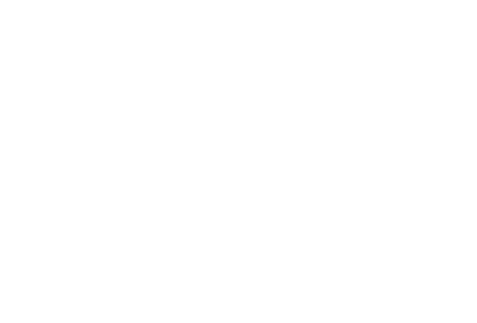

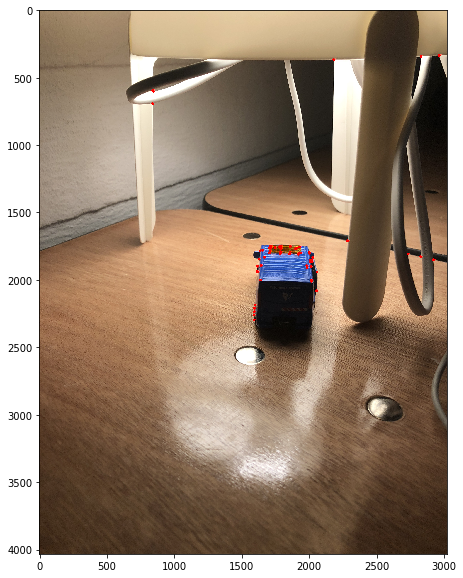

In [211]:
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

frame = cv2.imread('archive/IMG_0102.JPG')
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# calculate optical flow
p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

check_alarm(frame.shape, p1, st, p0)

# Select good points
good_new = p1[st==1]
good_old = p0[st==1]
# draw the tracks
for i,(new,old) in enumerate(zip(good_new,good_old)):
    a,b = new.ravel()
    c,d = old.ravel()
    mask = cv2.line(mask, (a,b),(c,d), (0,0,255), 10)
    frame = cv2.circle(frame,(a,b), 5, (0,0,255), 10)
    
img = cv2.add(frame, mask)
show(img)

In [256]:
vidcap = cv2.VideoCapture('archive/IMG_0110.MOV')

In [408]:
def turn(image):
    rows,cols, _ = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-90,1)
    dst = cv2.warpAffine(image,M,(cols,rows))
    
    return dst

vidcap = cv2.VideoCapture('archive/IMG_0110.MOV')
success,image = vidcap.read()
count = 0
success = True
while success:
    success,image = vidcap.read()
    if (not success):
        break  
        
    image = turn(image)
    cv2.imwrite('frames/' + str(count) + '_frame.png', image)
    
    count += 1

In [342]:
import json
json_list = json.loads('[{"top": 190, "left": 1035, "bottom": 423, "right": 1459}, {"top": 11, "left": 401, "bottom": 121, "right": 502}]')

In [378]:
img = cv2.imread('first_frame.png')
for json in json_list:
    top = json['top']
    bottom = json['bottom']
    left = json['left']
    right = json['right']
    print(top, left, bottom, right)
    cv2.rectangle(img, (left,top),(right,bottom),(0,255,0),5)

(190, 1035, 423, 1459)
(11, 401, 121, 502)


### Production

In [519]:
def dist(x1,y1,x2,y2):
    return np.sqrt(np.power(x1-x2, 2) + np.power(y1-y2,2))

def check_alarm(global_shape, p1, st, p0):
    s1, s2, _ = global_shape
    global_dist = dist(s1, 0, s2, 0)
    good_new = p1[st==1]
    good_old = p0[st==1]
    
    number_of_points_with_long_dist = 0
    for i, (new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        print(dist(a,b,c,d))
        
        if (dist(a,b,c,d) / global_dist > 0.1):
            number_of_points_with_long_dist += 1
               
    return ((float)(number_of_points_with_long_dist) / len(p0[st==1]) > 0.1)

In [520]:
def cut_rectangle(rect_left, rect_top, rect_right, rect_bottom, img):
    s1, s2, _ = img.shape
    cuted_img = img[rect_top:rect_bottom, rect_left:rect_right, :]
    
    return cuted_img

def check_for_stealing(rect_left, rect_top, rect_right, rect_bottom, first_img_path, second_img_path):
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 1000, 
                           qualityLevel = 0.3, 
                           minDistance = 3, 
                           blockSize = 3)

    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (21, 21), 
                     maxLevel = 10, 
                     criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    # Take first frame and find corners in it
    first_img = cv2.imread(first_img_path)
    
    old_frame = cut_rectangle(rect_left, rect_top, rect_right, rect_bottom, first_img)
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
    
    second_img = cv2.imread(second_img_path)
    frame = cut_rectangle(rect_left, rect_top, rect_right, rect_bottom, second_img)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    
    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)
    
    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), (0,0,255), 2)
        frame = cv2.circle(frame,(a,b), 5, (0,0,255), 2)
    
    img = cv2.add(frame, mask)
    show(img)
    
    check_alarm(frame.shape, p1, st, p0)
    
    return old_frame, frame

In [517]:
import json
json_coordinates = json.loads('{"top": 190, "left": 1035, "bottom": 423, "right": 1459}')

top = json_coordinates['top']
bottom = json_coordinates['bottom']
left = json_coordinates['left']
right = json_coordinates['right']
print(top, left, bottom, right)

(190, 1035, 423, 1459)


In [478]:
import glob
first_frame = 'frames/0_frame.png'
for i in np.arange(138):
    if (i == 100):
        continue
    path_to_img = 'frames/' + str(i) + '_frame.png'
    is_steal = check_for_stealing(left, top, right, bottom, 'frames/0_frame.png' , path_to_img)
    
    if (is_steal):
        print('SOS in ' + i) 

0.0532354283114
0.0552144187448
0.072297303913
0.0550640295515
0.0555318758555
0.0531522963938
0.0549746464214
0.0524760030384
0.0745328730824
0.0536363913395
0.0529660750155
0.0544212259055
0.0543536628676
0.0554412311332
0.0505961546756
0.0532753722899
0.0530791041238
0.0607839539391
0.0531162880763
0.0553339571437
0.0547082720103
0.0541667792539
0.0554593647283
0.0532781180606
0.053243612035
0.0539866850675
0.054159264678
0.0520095022338
0.0519420075692
0.0521147871024
0.0538705423412
0.0663389945994
0.0530374225926
0.0525713744144
0.0544806184764
0.0641580864642
0.0507704878416
0.0530830262154
0.0675336046115
0.054265135443
0.0516723083578
0.0504736056168
0.0547989985018
0.0553675116303
0.0535960283198
0.0520733487434
0.0520456492299
0.0526373322303
0.0541147196306
0.0527076227593
0.0549836975669
0.054207345885
0.0505411227861
0.0581884111393
0.0542997930985
0.0523515211952
0.0524406316448
0.0517072126087
0.0534995420689
0.0510824874207
('number_of_points_with_long_dist:', 0)
('num

112.832561479
121.327449761
33.1559950614
56.7103871294
76.4815111081
44.3369815292
56.0775081972
42.0882143494
212.189681725
172.225879649
2.93909583093
61.4793073487
213.467639002
122.488287539
137.161451112
70.9655656091
48.0790536304
168.97834677
56.8495370785
122.003544824
82.7455742634


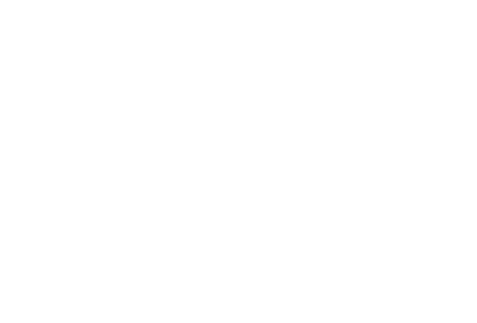

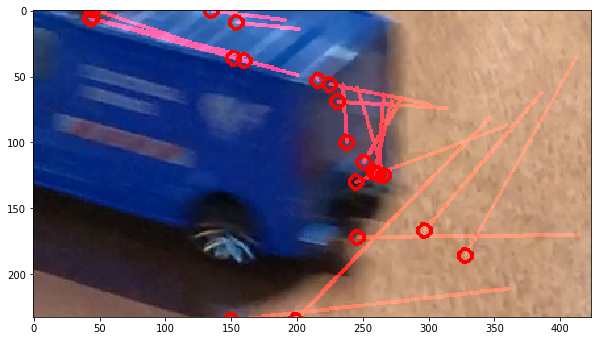

In [521]:
old_frame, frame = check_for_stealing(left, top, right, bottom, 'frames/0_frame.png', 'frames/85_frame.png')